In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder\
        .master("local[1]")\
        .appName("myapp")\
        .getOrCreate()

In [ ]:
df = spark.read.csv('dbfs:/FileStore/shared_uploads/l00179485@atu.ie/heart_2022_no_nans.csv', header='True', inferSchema='True')

In [ ]:
display(df)

In [ ]:
df.groupBy('LastCheckupTime').count().show(10,True)

+--------------------+------+
|     LastCheckupTime| count|
+--------------------+------+
|Within past 2 yea...| 23227|
|Within past 5 yea...| 13744|
| 5 or more years ago| 10898|
|Within past year ...|198153|
+--------------------+------+



In [ ]:
from pyspark.sql.functions import when
df = df.withColumn('last_checked',\
when(df['LastCheckupTime'] == "Within past year (anytime less than 12 months ago)", 1)\
  .when(df['LastCheckupTime'] == '5 or more years ago', 5)\
  .when(df['LastCheckupTime'] == 'Within past 2 years (1 year but less than 2 years ago)', 2)\
  .when(df['LastCheckupTime'] == 'Within past 5 years (2 years but less than 5 years ago)', 4)\
  .otherwise(df['LastCheckupTime']))

df.groupBy('last_checked').count().show(20)


+------------+------+
|last_checked| count|
+------------+------+
|           5| 10898|
|           1|198153|
|           4| 13744|
|           2| 23227|
+------------+------+



In [ ]:

df.groupBy('TetanusLast10Tdap').count().show(20)

+--------------------+-----+
|   TetanusLast10Tdap|count|
+--------------------+-----+
|Yes, received tet...|74119|
|No, did not recei...|81747|
|  Yes, received Tdap|70286|
|Yes, received tet...|19870|
+--------------------+-----+



In [ ]:
df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

In [ ]:
df.dropna()

DataFrame[State: string, Sex: string, GeneralHealth: string, PhysicalHealthDays: double, MentalHealthDays: double, LastCheckupTime: string, PhysicalActivities: string, SleepHours: double, RemovedTeeth: string, HadHeartAttack: string, HadAngina: string, HadStroke: string, HadAsthma: string, HadSkinCancer: string, HadCOPD: string, HadDepressiveDisorder: string, HadKidneyDisease: string, HadArthritis: string, HadDiabetes: string, DeafOrHardOfHearing: string, BlindOrVisionDifficulty: string, DifficultyConcentrating: string, DifficultyWalking: string, DifficultyDressingBathing: string, DifficultyErrands: string, SmokerStatus: string, ECigaretteUsage: string, ChestScan: string, RaceEthnicityCategory: string, AgeCategory: string, HeightInMeters: double, WeightInKilograms: double, BMI: double, AlcoholDrinkers: string, HIVTesting: string, FluVaxLast12: string, PneumoVaxEver: string, TetanusLast10Tdap: string, HighRiskLastYear: string, CovidPos: string, last_checked: string]

In [ ]:
df.count()

246022

In [ ]:
df.dropDuplicates

<bound method DataFrame.dropDuplicates of DataFrame[State: string, Sex: string, GeneralHealth: string, PhysicalHealthDays: double, MentalHealthDays: double, LastCheckupTime: string, PhysicalActivities: string, SleepHours: double, RemovedTeeth: string, HadHeartAttack: string, HadAngina: string, HadStroke: string, HadAsthma: string, HadSkinCancer: string, HadCOPD: string, HadDepressiveDisorder: string, HadKidneyDisease: string, HadArthritis: string, HadDiabetes: string, DeafOrHardOfHearing: string, BlindOrVisionDifficulty: string, DifficultyConcentrating: string, DifficultyWalking: string, DifficultyDressingBathing: string, DifficultyErrands: string, SmokerStatus: string, ECigaretteUsage: string, ChestScan: string, RaceEthnicityCategory: string, AgeCategory: string, HeightInMeters: double, WeightInKilograms: double, BMI: double, AlcoholDrinkers: string, HIVTesting: string, FluVaxLast12: string, PneumoVaxEver: string, TetanusLast10Tdap: string, HighRiskLastYear: string, CovidPos: string, 

In [ ]:
df.count()

246022

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
df = df.withColumn('Heart_disease',\
    when((col('HadHeartAttack')== 'Yes')| (col('HadAngina')=='Yes'), 1)
    .otherwise(0))
df = df.withColumn("Heart_disease", col("Heart_disease").cast("double"))

In [ ]:
count_heart_disease = df.select('Heart_disease').groupBy('Heart_disease').count().show()
total = df.count()
percentage_count = df.groupBy("Heart_disease") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group')/total) * 100)
  


+-------------+------+
|Heart_disease| count|
+-------------+------+
|          0.0|224406|
|          1.0| 21616|
+-------------+------+



224406
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            2 non-null      object 
 1   sum_per_group  2 non-null      int64  
 2   perc           2 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 176.0+ bytes
+------+----+
|   Sex|perc|
+------+----+
|Female|40.0|
|  Male|60.0|
+------+----+

+------+----+
|   Sex|perc|
+------+----+
|Female|53.0|
|  Male|47.0|
+------+----+



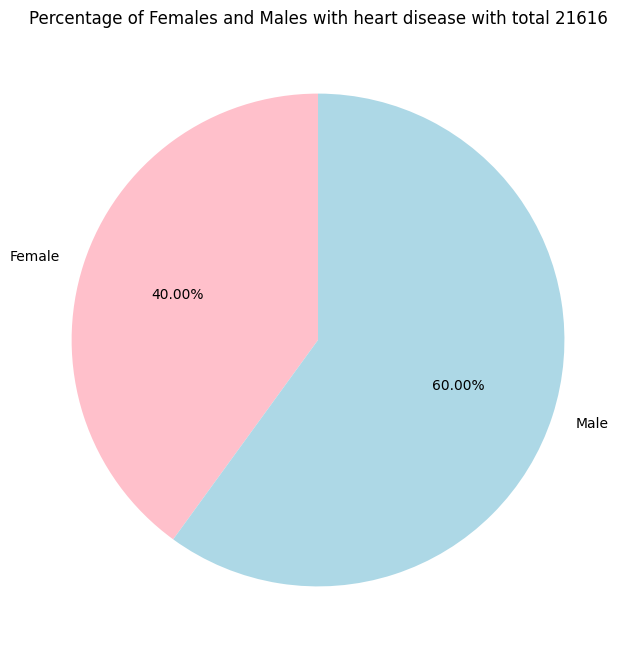

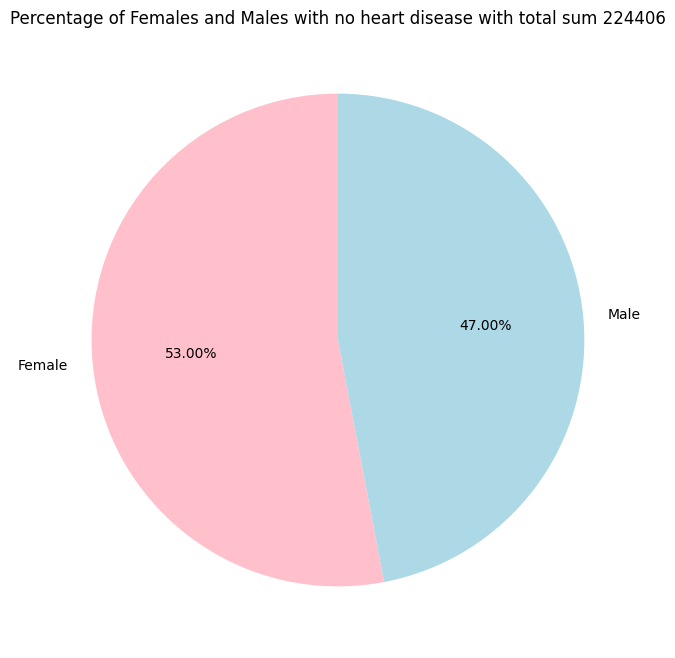

"\ndf_male_count = df.filter(df.Sex == 'Male').groupBy('Heart_Disease').count()                .withColumnRenamed('count', 'cnt_per_group')                .withColumn('perc', (F.col('cnt_per_group')/total) * 100)\n\ndf_female_count = df.filter(df.Sex == 'Female').groupBy('Heart_Disease').count()                .withColumnRenamed('count', 'cnt_per_group')                .withColumn('perc', (F.col('cnt_per_group')/total) * 100)\n\ndf_heart__count.show()\n#print(df_orignal)\ndf_male_count.show()\ndf_female_count.show()"

In [ ]:
from pyspark.sql.functions import col, avg, count

df_heart__count = df.select('Sex', 'Heart_disease').filter(df.Heart_disease == 1)
df_heart__count_no = df.select('Sex', 'Heart_disease').filter(df.Heart_disease == 0)
#df_heart__count.show()
sum1 = df_heart__count.count()
sum2 = df_heart__count_no.count()
print(sum2)
#df_heart__count_no.show()

df_heart__count2 = df_heart__count.groupBy('Sex').count()\
       .withColumnRenamed('count', 'sum_per_group')\
       .withColumn('perc', F.round((F.col('sum_per_group')/sum1) * 100))

df_heart__count2_no = df_heart__count_no.groupBy('Sex').count()\
       .withColumnRenamed('count', 'sum_per_group')\
       .withColumn('perc', F.round((F.col('sum_per_group')/sum2) * 100))


sex_perc_Y = df_heart__count2.toPandas()
sex_perc_N = df_heart__count2_no.toPandas()
sex_perc_Y.info()
df_heart__count2.select('Sex', 'perc').show()
df_heart__count2_no.select('Sex', 'perc').show()

plt.figure(figsize=(8, 8))
plt.pie(sex_perc_Y['perc'], labels=sex_perc_Y['Sex'], autopct='%1.2f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title(f'Percentage of Females and Males with heart disease with total {sum1}')
plt.show()


plt.figure(figsize=(8, 8))
plt.pie(sex_perc_N['perc'], labels=sex_perc_N['Sex'], autopct='%1.2f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title(f'Percentage of Females and Males with no heart disease with total sum {sum2}')
plt.show()
"""
total_race_df = df.select('RaceEthnicityCategory', 'Heart_disease').filter(df.Heart_disease == 1)
#df.select('RaceEthnicityCategory', 'heart_disease')
total_race = total_race_df.count()

race_df = total_race_df.groupBy('RaceEthnicityCategory').count()\
       .withColumnRenamed('count', 'sum_per_group')\
       .withColumn('perc', F.round((F.col('sum_per_group')/total_race) * 100))

race_df.show()
race = race_df.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(race['perc'], race['RaceEthnicityCategory'], autopct='%1.2f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title(f'Distribution of Heart Disease Across Ethnicities')
plt.show()

"""

"""
df_male_count = df.filter(df.Sex == 'Male').groupBy('Heart_Disease').count()\
                .withColumnRenamed('count', 'cnt_per_group')\
                .withColumn('perc', (F.col('cnt_per_group')/total) * 100)

df_female_count = df.filter(df.Sex == 'Female').groupBy('Heart_Disease').count()\
                .withColumnRenamed('count', 'cnt_per_group')\
                .withColumn('perc', (F.col('cnt_per_group')/total) * 100)

df_heart__count.show()
#print(df_orignal)
df_male_count.show()
df_female_count.show()"""

In [ ]:
"""total_race_df = df.select('RaceEthnicityCategory', 'Heart_disease')
#df.select('RaceEthnicityCategory', 'heart_disease')
total_race = total_race_df.count()
race_df = df.groupBy('RaceEthnicityCategory').agg(
    F.count('Heart_disease').alias('count_per_group'),
    F.round((F.count('Heart_disease') / total_race) * 100, 2).alias('perc')
)
total_race_df.show()
race = race_df.toPandas()
race_df.show()

plt.figure(figsize=(12, 8))
sns.catplot(x='RaceEthnicityCategory', y='count_per_group', hue='Heart_disease', data=race, kind='bar', palette='viridis')
plt.suptitle('Count of Occurrences based on Heart Disease and Ethnicity', y=1.02)
plt.show()"""

"total_race_df = df.select('RaceEthnicityCategory', 'Heart_disease')\n#df.select('RaceEthnicityCategory', 'heart_disease')\ntotal_race = total_race_df.count()\nrace_df = df.groupBy('RaceEthnicityCategory').agg(\n    F.count('Heart_disease').alias('count_per_group'),\n    F.round((F.count('Heart_disease') / total_race) * 100, 2).alias('perc')\n)\ntotal_race_df.show()\nrace = race_df.toPandas()\nrace_df.show()\n\nplt.figure(figsize=(12, 8))\nsns.catplot(x='RaceEthnicityCategory', y='count_per_group', hue='Heart_disease', data=race, kind='bar', palette='viridis')\nplt.suptitle('Count of Occurrences based on Heart Disease and Ethnicity', y=1.02)\nplt.show()"

In [ ]:
"""disease_columns = ['HadDiabetes', 'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadStroke', 'HadSkinCancer', 'HadDepressiveDisorder']

# Convert 'DiseaseType' columns to numerical values (0 for 'No', 1 for 'Yes')
for column in disease_columns:
    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))

# Group by BMI and calculate the average numeric column for each disease status
avg_bmi_df = df.groupBy('BMI').agg(*[F.avg(column).alias(f'avg_{column}') for column in disease_columns])

# Convert to Pandas DataFrame for Seaborn plotting
melted_df = avg_bmi_df.toPandas().melt(id_vars=['BMI'], var_name='DiseaseType', value_name='avg_numeric_column')

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='BMI', y='avg_numeric_column', hue='DiseaseType')
plt.xlabel('BMI')
plt.ylabel('Average Numeric Value')
plt.title('Comparison of Diseases in Relation to BMI')
plt.legend(title='Disease Type')
plt.grid(True)
plt.show()"""

"disease_columns = ['HadDiabetes', 'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadStroke', 'HadSkinCancer', 'HadDepressiveDisorder']\n\n# Convert 'DiseaseType' columns to numerical values (0 for 'No', 1 for 'Yes')\nfor column in disease_columns:\n    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))\n\n# Group by BMI and calculate the average numeric column for each disease status\navg_bmi_df = df.groupBy('BMI').agg(*[F.avg(column).alias(f'avg_{column}') for column in disease_columns])\n\n# Convert to Pandas DataFrame for Seaborn plotting\nmelted_df = avg_bmi_df.toPandas().melt(id_vars=['BMI'], var_name='DiseaseType', value_name='avg_numeric_column')\n\n# Plotting with Seaborn\nplt.figure(figsize=(12, 8))\nsns.barplot(data=melted_df, x='BMI', y='avg_numeric_column', hue='DiseaseType')\nplt.xlabel('BMI')\nplt.ylabel('Average Numeric Value')\nplt.title('Comparison of Diseases in Relation to BMI')\nplt.legend(title='Disease Type')\nplt.grid(True)\nplt.show()"

In [ ]:
display(percentage_count)

Heart_disease,cnt_per_group,perc_of_count_total
0.0,224406,91.21379388835145
1.0,21616,8.786206111648552


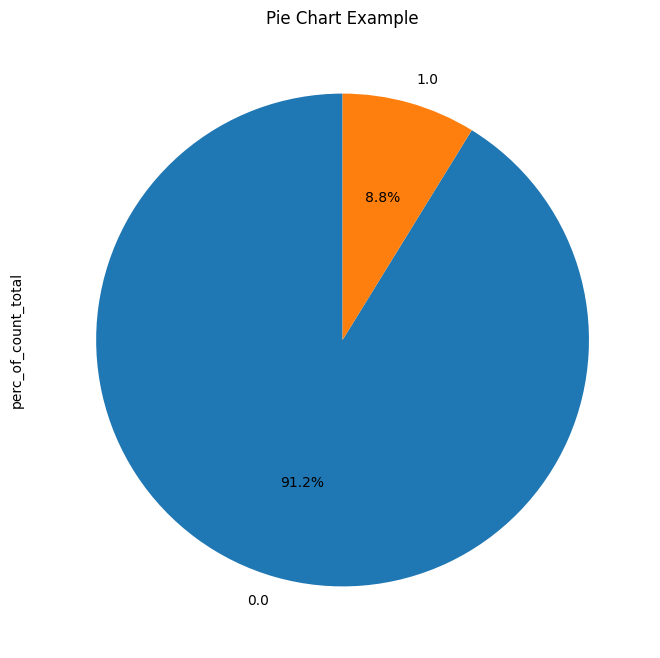

In [ ]:

per = percentage_count.toPandas()
plt.figure(figsize=(8, 8))
per.set_index("Heart_disease")["perc_of_count_total"].plot(kind="pie", autopct='%1.1f%%', startangle=90, legend=False)
plt.title("Pie Chart Example")
plt.show()

<Figure size 1200x800 with 0 Axes>

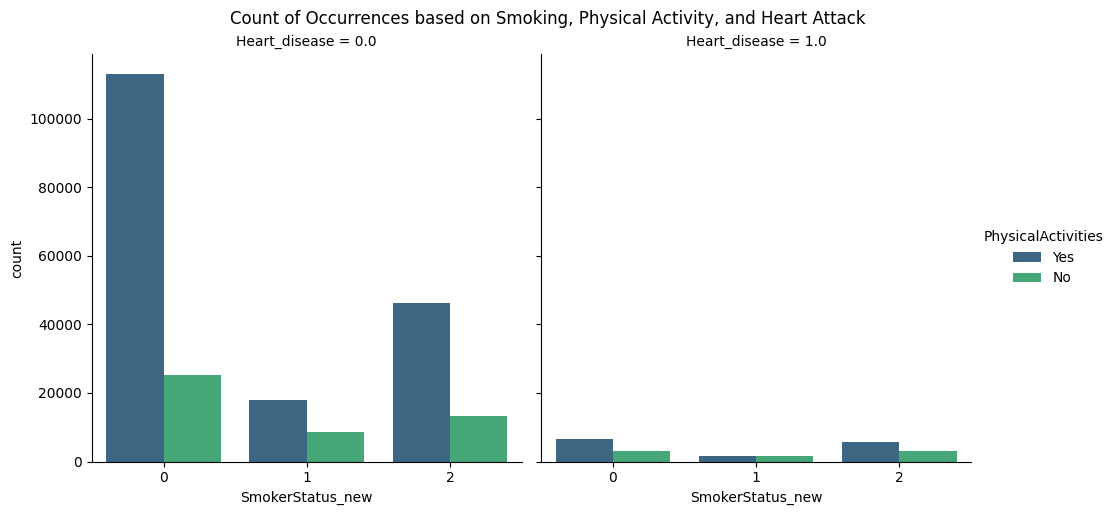

In [ ]:
#distribution of people who smokes and physical activity
df_smoke = df.select('PhysicalActivities', 'SmokerStatus', 'Heart_disease')
df_smoke = df_smoke.withColumn('SmokerStatus_new',\
    when((col('SmokerStatus')== 'Never smoked'), 0)
    .when((col('SmokerStatus')== 'Former smoker'), 2)
    
    .otherwise(1))
#df_smoke.select('SmokerStatus_new').show()
df_smoke1 = df_smoke.toPandas()
plt.figure(figsize=(12, 8))
sns.catplot(x='SmokerStatus_new', hue='PhysicalActivities', col='Heart_disease', data=df_smoke1, kind='count', palette='viridis')
plt.suptitle('Count of Occurrences based on Smoking, Physical Activity, and Heart Attack', y=1.02)
plt.show()

<Figure size 1200x800 with 0 Axes>

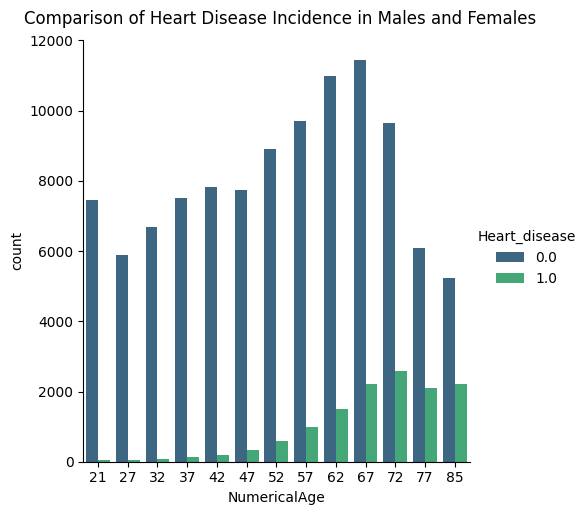

<Figure size 1200x800 with 0 Axes>

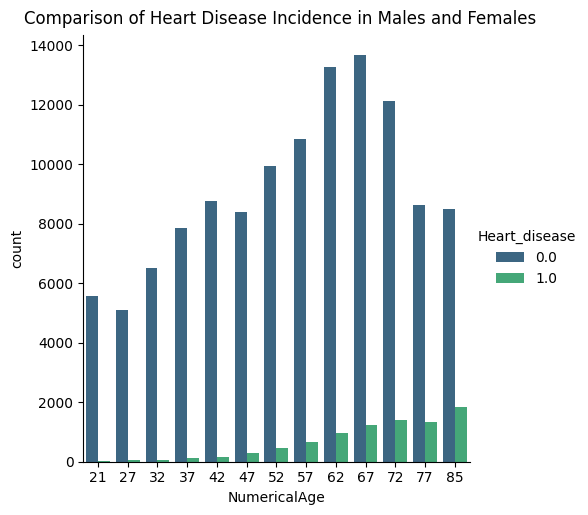

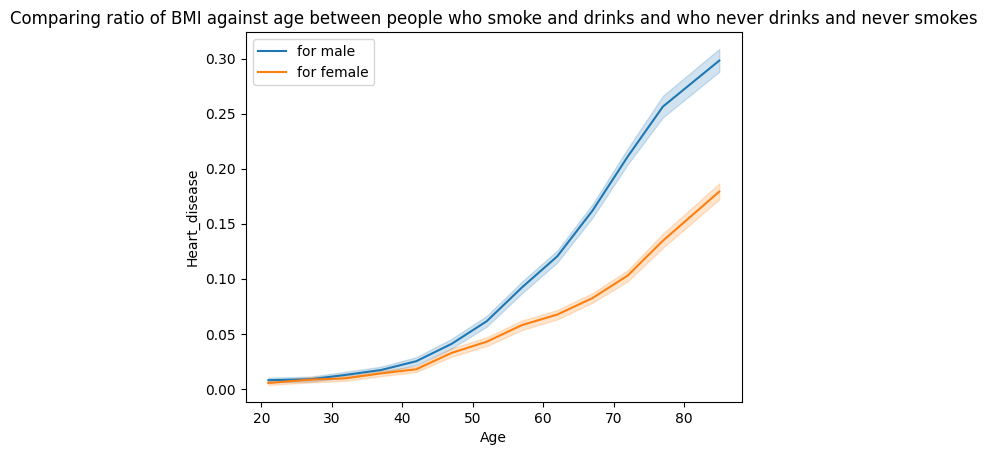

In [ ]:
df_sex = df.select('sex', 'Heart_disease', 'AgeCategory')
#df_sex.show()
df_sex = df_sex.toPandas()
age_mapping = {
    'Age 18 to 24': 21,
    'Age 25 to 29': 27,
    'Age 30 to 34': 32,
    'Age 35 to 39': 37,
    'Age 40 to 44': 42,
    'Age 45 to 49': 47,
    'Age 50 to 54': 52,
    'Age 55 to 59': 57,
    'Age 60 to 64': 62,
    'Age 65 to 69': 67,
    'Age 70 to 74': 72,
    'Age 75 to 79': 77,
    'Age 80 or older': 85  # Assuming "80 or older" is a reasonable representation
}

df_sex['NumericalAge'] = df_sex['AgeCategory'].map(age_mapping)
df_male = df_sex[df_sex['sex']=='Male']
df_female = df_sex[df_sex['sex']=='Female']
# Create a line graph
plt.figure(figsize=(12, 8))
sns.catplot(x='NumericalAge', hue='Heart_disease', data=df_male, kind='count', palette='viridis')

plt.suptitle('Comparison of Heart Disease Incidence in Males and Females', y=1.02)
plt.show()

plt.figure(figsize=(12, 8))

sns.catplot(x='NumericalAge', hue='Heart_disease', data=df_female, kind='count', palette='viridis')
plt.suptitle('Comparison of Heart Disease Incidence in Males and Females', y=1.02)
plt.show()



sns.lineplot(x=df_male['NumericalAge'], y=df_male.Heart_disease, label="for male")
sns.lineplot(x=df_female['NumericalAge'], y=df_female.Heart_disease, label="for female")
plt.xlabel("Age")
plt.ylabel("Heart_disease")
plt.title("Comparing ratio of BMI against age between people who smoke and drinks and who never drinks and never smokes")
plt.legend()
plt.show()

In [ ]:
df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

In [ ]:
df.groupBy('Heart_disease').count().show()
df.select('Heart_disease').groupBy().count().show()

+-------------+------+
|Heart_disease| count|
+-------------+------+
|          0.0|224406|
|          1.0| 21616|
+-------------+------+

+------+
| count|
+------+
|246022|
+------+



In [ ]:
df1 = df.drop(*['HadHeartAttack', 'HadAngina' ])

In [ ]:
len(df1.columns)


40

In [ ]:
male_df = df1.filter(df.Sex== 'Male')
female_df = df1.filter(df.Sex== 'Female')

male = male_df.toPandas()
female = female_df.toPandas()

male["AgeCategory"] = male["AgeCategory"].str.replace("or older", ">=").str.replace("to", "-").str.replace("Age", "").str.strip()

female["AgeCategory"] =female["AgeCategory"].str.replace("or older", ">=").str.replace("to", "-").str.replace("Age", "").str.strip()

print(male['AgeCategory'].unique())
#print(df1.select('Sex').show())

['70 - 74' '75 - 79' '50 - 54' '40 - 44' '80 >=' '60 - 64' '65 - 69'
 '45 - 49' '55 - 59' '30 - 34' '18 - 24' '35 - 39' '25 - 29']


In [ ]:
"""Sexn  = df_orignal[df_orignal['Heart_disease'] == "No"]['Sex'].value_counts()
Sexn = [Sexn[0] / sum(Sexn) * 100, Sexn[1] / sum(Sexn) * 100] # Female - Male
plt.subplot(6,4,9)
plt.pie(Sex,labels = ['Female', 'Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = color_ye,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Sex')
plt.figtext(0.3,0.95,"HeartDisease : Yes", va="center", ha="center", size=20)
plt.figtext(0.7,0.95,"HeartDisease: No", va="center", ha="center", size=20)



plt.suptitle('HeartDisease',fontsize=20)
plt.subplots_adjust(top=0.92)"""

'Sexn  = df_orignal[df_orignal[\'Heart_disease\'] == "No"][\'Sex\'].value_counts()\nSexn = [Sexn[0] / sum(Sexn) * 100, Sexn[1] / sum(Sexn) * 100] # Female - Male\nplt.subplot(6,4,9)\nplt.pie(Sex,labels = [\'Female\', \'Male\'],autopct=\'%1.1f%%\',startangle = 90,explode = (0.1,0),colors = color_ye,\n       wedgeprops = {\'edgecolor\' : \'black\',\'linewidth\': 1,\'antialiased\' : True})\nplt.title(\'Sex\')\nplt.figtext(0.3,0.95,"HeartDisease : Yes", va="center", ha="center", size=20)\nplt.figtext(0.7,0.95,"HeartDisease: No", va="center", ha="center", size=20)\n\n\n\nplt.suptitle(\'HeartDisease\',fontsize=20)\nplt.subplots_adjust(top=0.92)'

In [ ]:
male.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos', 'last_checked', 'Heart_disease'],
      dtype='object')

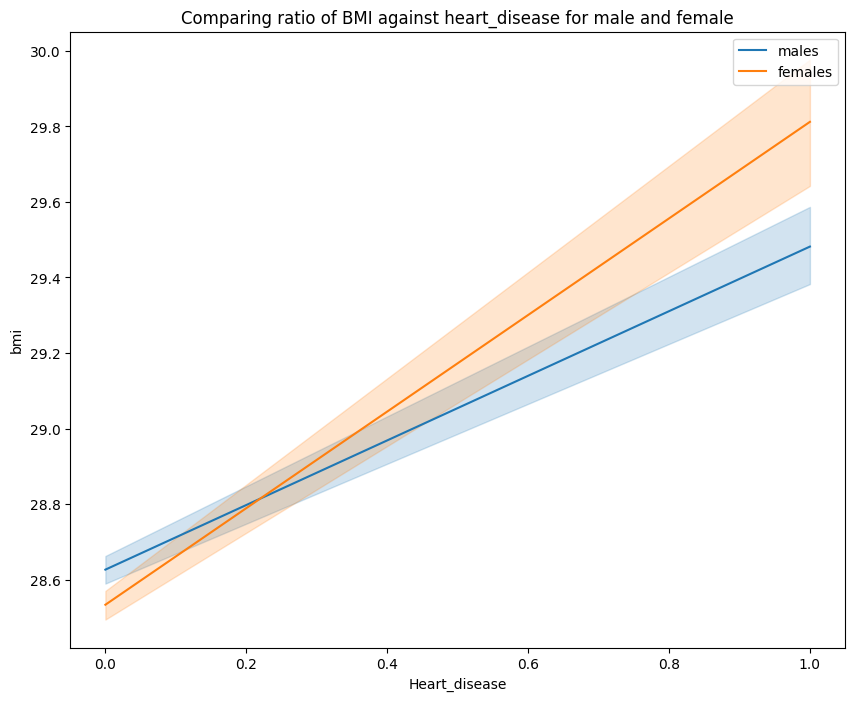

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.lineplot(x=male.Heart_disease, y=male.BMI, label="males")
sns.lineplot(x=female.Heart_disease, y=female.BMI, label="females")

plt.xlabel("Heart_disease")
plt.ylabel("bmi")
plt.title("Comparing ratio of BMI against heart_disease for male and female")
plt.legend()

In [ ]:
column_info = df1.dtypes
print(column_info)
objects = []
numbers = []
for col_name, type in column_info:
    if type == 'string':
        objects.append(col_name)
    else:
        numbers.append(col_name)
#objects.remove('Heart_disease')
print(objects)
obj_len = len(objects)
print("objects: " + str(obj_len))

numbers.remove('Heart_disease')
print(numbers)
print(len(numbers))

[('State', 'string'), ('Sex', 'string'), ('GeneralHealth', 'string'), ('PhysicalHealthDays', 'double'), ('MentalHealthDays', 'double'), ('LastCheckupTime', 'string'), ('PhysicalActivities', 'string'), ('SleepHours', 'double'), ('RemovedTeeth', 'string'), ('HadStroke', 'string'), ('HadAsthma', 'string'), ('HadSkinCancer', 'string'), ('HadCOPD', 'string'), ('HadDepressiveDisorder', 'string'), ('HadKidneyDisease', 'string'), ('HadArthritis', 'string'), ('HadDiabetes', 'string'), ('DeafOrHardOfHearing', 'string'), ('BlindOrVisionDifficulty', 'string'), ('DifficultyConcentrating', 'string'), ('DifficultyWalking', 'string'), ('DifficultyDressingBathing', 'string'), ('DifficultyErrands', 'string'), ('SmokerStatus', 'string'), ('ECigaretteUsage', 'string'), ('ChestScan', 'string'), ('RaceEthnicityCategory', 'string'), ('AgeCategory', 'string'), ('HeightInMeters', 'double'), ('WeightInKilograms', 'double'), ('BMI', 'double'), ('AlcoholDrinkers', 'string'), ('HIVTesting', 'string'), ('FluVaxLast

In [ ]:
(traindf, testdf) = df1.randomSplit([0.8, 0.2])

In [ ]:
df.columns

['State',
 'Sex',
 'GeneralHealth',
 'PhysicalHealthDays',
 'MentalHealthDays',
 'LastCheckupTime',
 'PhysicalActivities',
 'SleepHours',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'HeightInMeters',
 'WeightInKilograms',
 'BMI',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos',
 'last_checked',
 'Heart_disease']

In [ ]:
from pyspark.ml.feature import StringIndexer
object_df = df1.drop(*numbers)
Heart_Diesease_Indexer = StringIndexer(inputCol="Heart_disease", outputCol="Heart_Disease_indexed").fit(df1)
#object_df2 = object_df.drop("Heart_Disease")
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_indexed").fit(object_df) for column in objects]
#uniqueCarrierIndexer = StringIndexer(inputCol="UNIQUE_CARRIER", outputCol="Indexed_UNIQUE_CARRIER").fit(df)                        
#indexer.setHandleInvalid("error")
#object_indexed = indexer.transform(object_df)
#df_transformed = indexer.transform(df)

#print(indexers)
indexed_objects = list(map(lambda x: f"{x}_indexed", objects))

#indexers.show()
print(Heart_Diesease_Indexer)

StringIndexerModel: uid=StringIndexer_417c590e3519, handleInvalid=error


In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=indexed_objects + numbers,
    outputCol='features'

)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

In [ ]:
pca = PCA(k=6, inputCol="scaled_features", outputCol="pca_features")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression


In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol='Heart_disease', numTrees=10,  maxBins=100)
lg = LogisticRegression(featuresCol="features", labelCol='Heart_disease')

In [ ]:
lst = [rf, lg]


In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [Heart_Diesease_Indexer , assembler, scaler, pca, rf])
model = pipeline.fit(traindf)
pipeline2 = Pipeline(stages=indexers + [Heart_Diesease_Indexer , assembler, scaler, pca, lg])
model2 = pipeline.fit(traindf)


In [ ]:
cumulative_variance = model.stages[-2].explainedVariance.cumsum()
print(f"Explained Variance Ratio (Cumulative) for : {cumulative_variance}")
    

Explained Variance Ratio (Cumulative) for : [0.11095385 0.18282732 0.24056395 0.287402   0.32781594 0.36295411]


In [ ]:
undersampled_df = df.sampleBy("Heart_disease", fractions={0: 0.2, 1: 1.0}, seed=42)
under_train_data, under_test_data = undersampled_df.randomSplit([0.8, 0.2], seed=42)
model_sampled = pipeline.fit(under_train_data)

In [ ]:

pred_sampled = model_sampled.transform(under_test_data)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_new = MulticlassClassificationEvaluator(labelCol="Heart_disease", predictionCol="prediction")
accuracy_new = evaluator_new.evaluate(pred_sampled)
print("Accuracy = %g" % accuracy_new)

Accuracy = 0.736615


In [ ]:
# Transform the data
result = model.transform(df)

# Show the result
result.select("pca_features").show(truncate=False)

# Show the explained variance ratio (information proportion)
#print("Explained Variance Ratio (Information Proportion): ", model.explainedVariance.toArray())


+--------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------+
|[0.3831628672216803,2.6546508471558843,0.9361110823870522,-0.3083812736762428,0.47172823933515157,0.6230330185767192]     |
|[0.3631834668839095,1.6765758087461728,-1.6191186199773322,-0.2321794200913334,0.2861863051565546,-0.09415880220100943]   |
|[-1.792169378756737,0.32825791239174645,-2.33009477983409,-1.3156701781342834,0.09328758955417893,-1.5802958137485437]    |
|[-1.5330851429489651,1.575688566885849,0.2143740640202566,0.12977234091946824,0.7257813515123848,1.4146617018751706]      |
|[-0.3038950237040278,1.2679355521223057,1.1162178823454436,0.2577465651600227,1.5863858808277598,0.4135048250026401]      |


In [ ]:
pred = model.transform(testdf)
pred2 = model2.transform(testdf)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Heart_disease", predictionCol="prediction")
accuracy = evaluator.evaluate(pred)
print(evaluator)
print("Accuracy = %g" % accuracy)


MulticlassClassificationEvaluator_82084894eead
Accuracy = 0.871784
DataFrame[State: string, Sex: string, GeneralHealth: string, PhysicalHealthDays: double, MentalHealthDays: double, LastCheckupTime: string, PhysicalActivities: string, SleepHours: double, RemovedTeeth: string, HadStroke: string, HadAsthma: string, HadSkinCancer: string, HadCOPD: string, HadDepressiveDisorder: string, HadKidneyDisease: string, HadArthritis: string, HadDiabetes: string, DeafOrHardOfHearing: string, BlindOrVisionDifficulty: string, DifficultyConcentrating: string, DifficultyWalking: string, DifficultyDressingBathing: string, DifficultyErrands: string, SmokerStatus: string, ECigaretteUsage: string, ChestScan: string, RaceEthnicityCategory: string, AgeCategory: string, HeightInMeters: double, WeightInKilograms: double, BMI: double, AlcoholDrinkers: string, HIVTesting: string, FluVaxLast12: string, PneumoVaxEver: string, TetanusLast10Tdap: string, HighRiskLastYear: string, CovidPos: string, last_checked: stri

In [ ]:
#Random Over sampling or undersampling
#Kfold cross validation
